# Final Notebook

# Importing Datasets

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns

import pydicom as dicom
from random import randint
import os, sys, time, shutil, scipy, cv2, json, datetime, pydicom
from tqdm.notebook import tqdm
from skimage import io
from glob import glob
import albumentations as A
from PIL import Image
from skimage.color import label2rgb
import random

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split

%reload_ext autoreload
%autoreload 2
from utils import *

## 2020 Training Dataset

In [4]:
# load metadata for 2020 training dataset and change column names
train = pd.read_csv('data/ISIC_2020_Training_GroundTruth_v2.csv')
train.columns = ['file', 'patient_id', 'lesion_id', 'gender', 'age', 'site', 'diagnosis', 'ben_mal', 'target']
train.head()

file  patient_id   lesion_id  gender   age             site  \
0  ISIC_2637011  IP_7279968  IL_7972535    male  45.0        head/neck   
1  ISIC_0015719  IP_3075186  IL_4649854  female  45.0  upper extremity   
2  ISIC_0052212  IP_2842074  IL_9087444  female  50.0  lower extremity   
3  ISIC_0068279  IP_6890425  IL_4255399  female  45.0        head/neck   
4  ISIC_0074268  IP_8723313  IL_6898037  female  55.0  upper extremity   

  diagnosis ben_mal  target  
0   unknown  benign       0  
1   unknown  benign       0  
2     nevus  benign       0  
3   unknown  benign       0  
4   unknown  benign       0

In [5]:
# display target count for dataset
train.target.value_counts()

0    32542
1      584
Name: target, dtype: int64

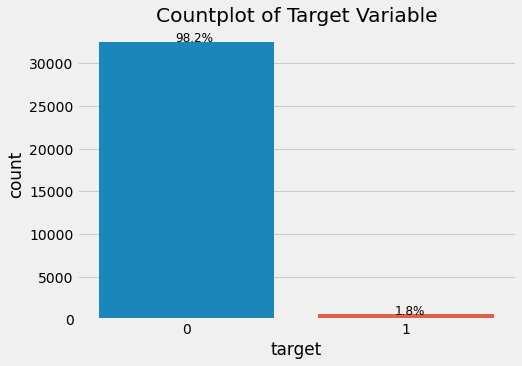

In [7]:
# make visualization to demonstrate class imbalance
def barplot(plot, feature, title):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
    plt.title(title)
    plt.show()

plt.figure(figsize= (7,5))
ax = sns.countplot(x='target', data=train)
barplot(ax, train.target, "Countplot of Target Variable")

## 2019 Training Dataset

This training dataset compiles the images from the following datasets:  BCN_2000, HAM1000, and MSK.  25,331 images were available for training across 8 different categories.  The metadata contains information about the age and gender of the patient, as well as the lesion ID and anatomical site.  There are 8 diagnostic categories:  Melanoma, nevus, basal cell carcinoma, acitinic keratosis, benign keratosis, deramtofibroma, vascular lession, squamous cell carcinoma, and unknown.

We subset the melanoma images and inserted them as additional samples of the minority class into our original dataset.

**Additional melanoma images:**  4522 

In [8]:
# Upload 2019 Training metadata to determine any additional instances of minority class
train19 = pd.read_csv('data/ISIC_2019_Training_GroundTruth.csv')
train19_2 = pd.read_csv('data/ISIC_2019_Training_Metadata.csv')
train19 = train19.rename(columns={'image':'image1'})
train19_2 = train19_2.rename(columns={'image':'image2'})
train2 = pd.concat([train19_2, train19], axis=1)
train2 = train2.drop(columns=['image1', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK'], axis=1)
train2.columns = ['file', 'age', 'site', 'lesion_id', 'gender', 'target']
train2.target = train2.target.astype(int)
train2.head()

file   age             site lesion_id  gender  target
0  ISIC_0000000  55.0   anterior torso       NaN  female       0
1  ISIC_0000001  30.0   anterior torso       NaN  female       0
2  ISIC_0000002  60.0  upper extremity       NaN  female       1
3  ISIC_0000003  30.0  upper extremity       NaN    male       0
4  ISIC_0000004  80.0  posterior torso       NaN    male       1

In [9]:
# Display target count for 2019 Training Dataset
train2.target.value_counts()

0    20809
1     4522
Name: target, dtype: int64

## 2018 Training Dataset

This dataset comes from the HAM10000 Dataset, and represents an over-representation of the malignancies in order to train for the different types of skin cancer.  This dataset is the training data for Task 3: Lesion DIagnosis, which consisted of 10015 images, and the columms correspond to the possible disease categories: melanoma, nevus, basal cell carcinoma, pigmented Bowen's, pigmented benign keratoses, dermatofibroma, and vascular.  Only one disease state is present for each lesion image.

We kept the melanoma images and insert those images into our original training dataset.

**Additional Melanoma images:**  1113 images

In [10]:

train18 = pd.read_csv('data/ISIC2018_Task3_Training_GroundTruth.csv')
train18_2 = pd.read_csv('data/ISIC2018_Task3_Training_LesionGroupings.csv')
train3 = train18_2.merge(train18, on='image', how='left')
train3 = train3.drop(columns=['NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], axis=1)
train3.columns = ['file', 'lesion_id', 'diagnosis', 'target']
train3.target = train3.target.astype(int)
train3.head()

file    lesion_id                         diagnosis  target
0  ISIC_0024306  HAM_0000550  serial imaging showing no change       0
1  ISIC_0024307  HAM_0003577  serial imaging showing no change       0
2  ISIC_0024308  HAM_0001477  serial imaging showing no change       0
3  ISIC_0024309  HAM_0000484  serial imaging showing no change       0
4  ISIC_0024310  HAM_0003350                    histopathology       1

In [11]:
train3.target.value_counts()

0    8902
1    1113
Name: target, dtype: int64

## Combining Dataframes

In [12]:
train2_mel = train2[train2.target == 1]
merge = pd.concat([train, train2_mel], axis=0, ignore_index=True)
train3_mel = train3[train3.target == 1]
tr_tot = pd.concat([merge, train3_mel], axis=0, ignore_index=True)
tr_tot.head()

file  patient_id   lesion_id  gender   age             site  \
0  ISIC_2637011  IP_7279968  IL_7972535    male  45.0        head/neck   
1  ISIC_0015719  IP_3075186  IL_4649854  female  45.0  upper extremity   
2  ISIC_0052212  IP_2842074  IL_9087444  female  50.0  lower extremity   
3  ISIC_0068279  IP_6890425  IL_4255399  female  45.0        head/neck   
4  ISIC_0074268  IP_8723313  IL_6898037  female  55.0  upper extremity   

  diagnosis ben_mal  target  
0   unknown  benign       0  
1   unknown  benign       0  
2     nevus  benign       0  
3   unknown  benign       0  
4   unknown  benign       0

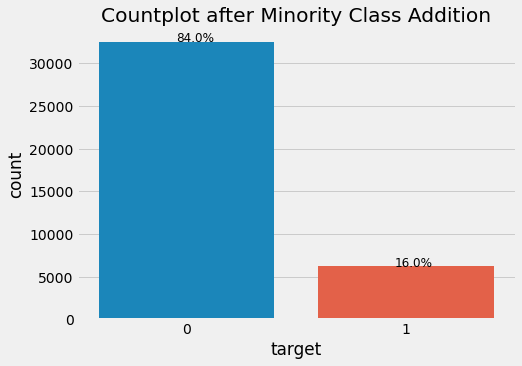

In [15]:
# display new target variable distribution
plt.figure(figsize= (7,5))
ax = sns.countplot(x='target', data=tr_tot)
barplot(ax, tr_tot.target, "Countplot after Minority Class Addition")

## Testing Dataset

Instead of taking more data from the original training dataset, we have decided to use the 2017 training dataset, totaling 2000 images as our testing/holdout dataset.  We opted not to use the 2020 testing datset because it did not have the corresponding labels.

In [30]:
test2a = pd.read_csv('data/ISIC-2017_Training_Data_metadata.csv')
test2a.columns = ['file', 'age', 'gender']
test2a = test2a.replace({'age': 'unknown'}, np.nan)
test2a = test2a.replace({'gender': 'unknown'}, np.nan)
test2b = pd.read_csv('data/ISIC-2017_Training_Part3_GroundTruth.csv')
test2b = test2b.drop(columns=['seborrheic_keratosis'], axis=1)
test2b.columns = ['file1', 'target']
test2b.target = test2b.target.astype(int)
test2 = pd.concat([test2a, test2b], axis=1)
test2 = test2.drop(columns=['file1'], axis=1)
test2.target.value_counts()

0    1626
1     374
Name: target, dtype: int64

In [22]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    2000 non-null   object
 1   age     2000 non-null   object
 2   gender  2000 non-null   object
 3   target  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


# Exploratory Data Analysis

For additional visualizations, please refer to the `EDA.ipynb` notebook.

I filled in the missing values in the training set when I was still thinking of combining the metadata and the image data into an ensemble method, which would require me to fill in missing values.  I left it out in the final notebook, as well as the visualizations comparing the testing and training dataset.  I chose to go with the 2017 dataset as the testing dataset, and it had much fewer columns than the 2020 testing dataset.  The 2020 testing dataset did not have labels, so I went with the 2017 dataset.

## Gender Distribution

Text(0.5, 1.0, 'Gender Distribution of Melanoma Patients')

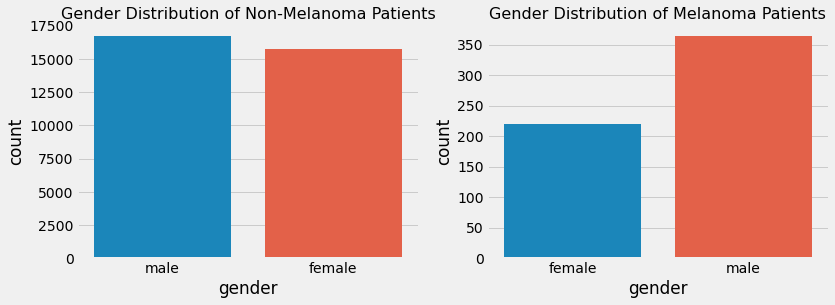

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='gender', data=train[train.target == 0], ax=ax1)
b = sns.countplot(x='gender', data=train[train.target == 1], ax=ax2)
ax1.set_title("Gender Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Gender Distribution of Melanoma Patients", fontsize=16)

Text(0.5, 1.0, 'Gender Distribution of Testing Set')

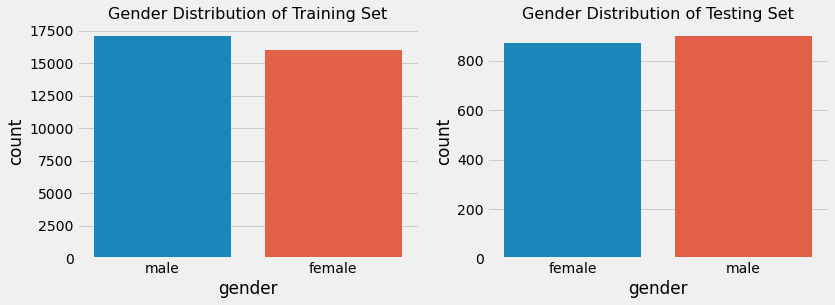

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='gender', data=train, ax=ax1)
b = sns.countplot(x='gender', data=test2, ax=ax2)
ax1.set_title("Gender Distribution of Training Set", fontsize=16)
ax2.set_title("Gender Distribution of Testing Set", fontsize=16)

## Age Distribution

Text(0.5, 1.0, 'Age Distribution of Melanoma Patients')

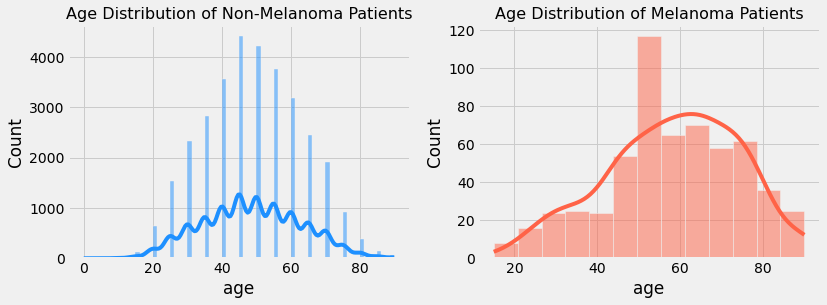

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train[train.target == 0], kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=train[train.target == 1], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Age Distribution of Melanoma Patients", fontsize=16)

In [32]:
test2.age = test2[~test2.age.isna()].age.astype(int)

Text(0.5, 1.0, 'Age Distribution of Testing Dataset')

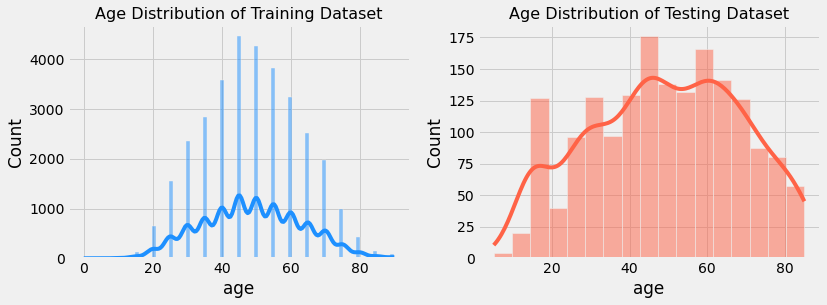

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='age', data=train, kde=True, color='dodgerblue', ax=ax1)
sns.histplot(x='age', data=test2[~test2.age.isna()], kde=True, color='tomato', ax=ax2)
ax1.set_title("Age Distribution of Training Dataset", fontsize=16)
ax2.set_title("Age Distribution of Testing Dataset", fontsize=16)

## Site Distribution

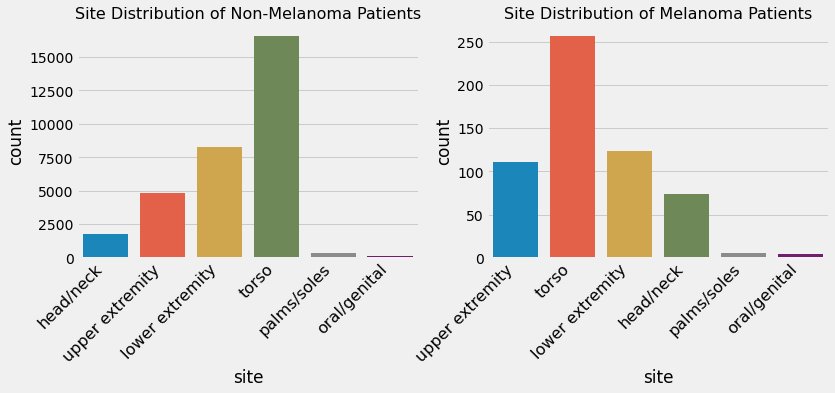

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
a = sns.countplot(x='site', data=train[train.target == 0], ax=ax1)
b = sns.countplot(x='site', data=train[train.target == 1], ax=ax2)
ax1.set_title("Site Distribution of Non-Melanoma Patients", fontsize=16)
ax2.set_title("Site Distribution of Melanoma Patients", fontsize=16)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45, fontsize=16, ha='right')

## Visualizing Melanoma, Non-melanoma and Transformations

To the layman, we can use the ABCDE's of Skin Cancer to identify what to look for in scanning for potential melanomas.  Just as a reminder:

1. Asymmetry
2. Border
3. Color
4. Diameter
5. Evolving

So that means a mole that is asymmetric, uneven in borders, varied in color (black, tan, or brown), larger in diameter than a pencil eraser, and/or evolving in size, shape, or color would be indicative of melanoma, and you should get it checked out immediately.


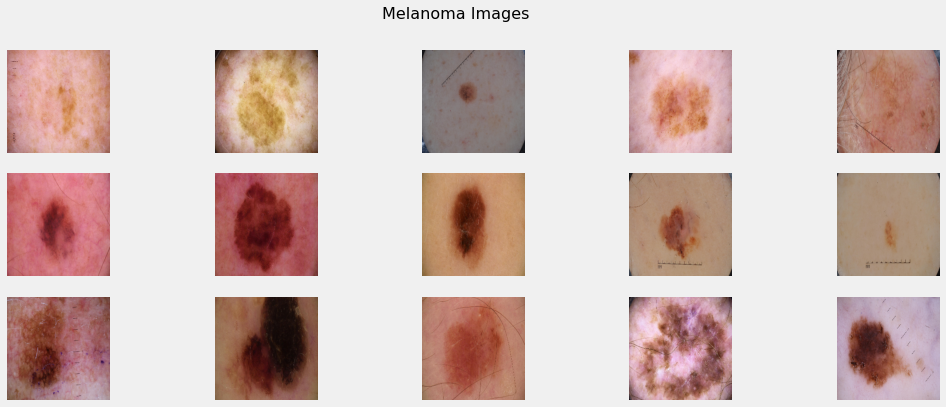

In [19]:
paths = glob('split/train/mel/2020/*.jpg')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,6))
plt.suptitle('Melanoma Images', fontsize=16)
for i in range(0, 15):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

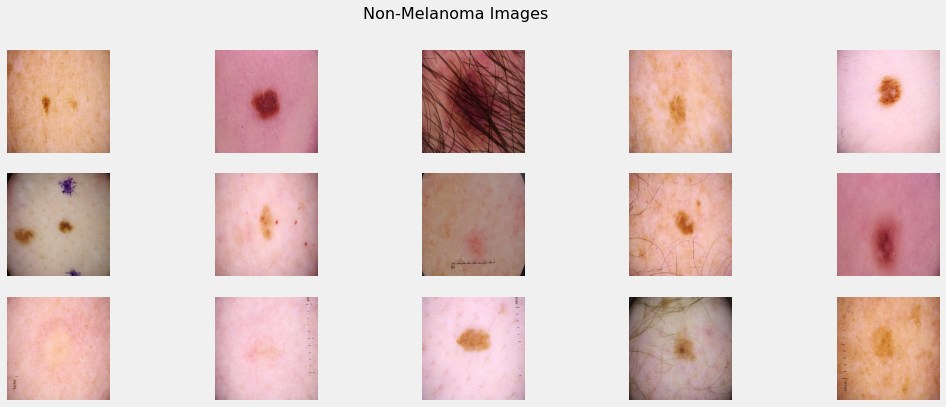

In [20]:
paths = glob('split/train/not_mel/*.jpg')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16,6))
plt.suptitle('Non-Melanoma Images', fontsize=16)
for i in range(0, 15):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    x = i // 5
    y = i % 5
    axes[x, y].imshow(image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

## Albumentations Transformations

For the entire set of visualizations of the different transformations, please refer to the `albumentation.ipynb` notebook.  Here we have display randomly 2 of the transformations.

We also implemented augmentations through DataImageGenerator, please refer to the `augmentation.ipynb` notebook, but it was not producing good metrics in terms of modeling.

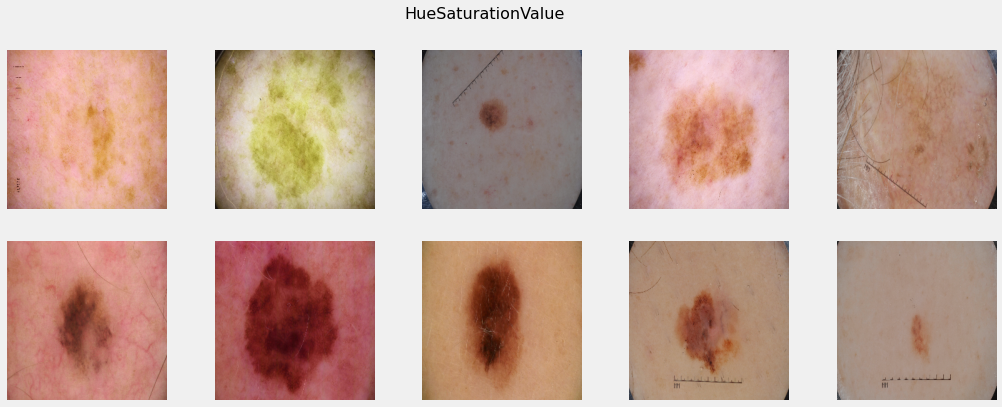

In [22]:
transform = A.Compose([
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10)
])

paths = glob('split/train/mel/2020/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('HueSaturationValue', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

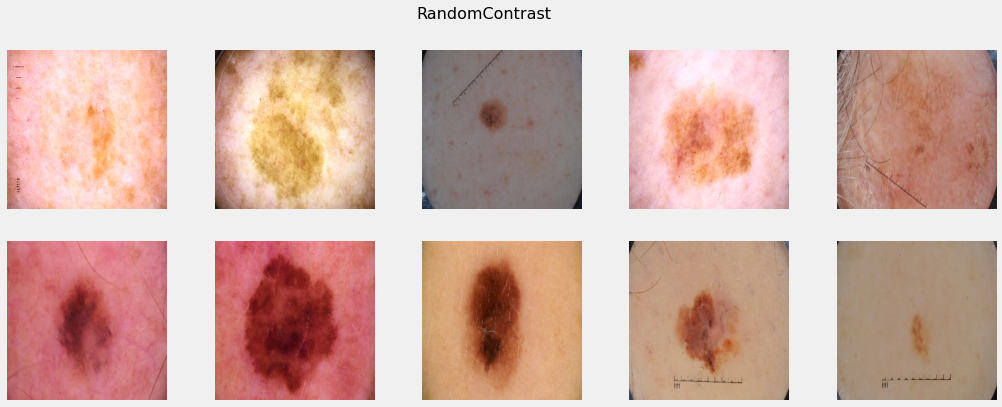

In [23]:
transform = A.Compose([
    A.RandomContrast(limit=0.3)
])

paths = glob('split/train/mel/2020/*.jpg')
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,6))
plt.suptitle('RandomContrast', fontsize=16)
for i in range(0, 10):   
    image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))
    transformed = transform(image=image)
    aug_image = transformed['image']
   
    x = i // 5
    y = i % 5
    axes[x, y].imshow(aug_image, cmap=plt.cm.bone)
    axes[x, y].axis('off')

## Code for Producing Transformations

We employed the following transformation on all the melanoma images from 2018, 2019, and 2020 datasets: 
- Transpose:  transpose input by sqapping rows and columns
- Vertical Flip: flip image vertically aorund x-axis
- Horizontal Flip:  flip input horizontally around y-axis
- CLAHE: apply contrast limited adaptive histogram equalization to input image 
- Cut Out: Coarse Dropout of the square regions in the image
- Gaussian Blur: Blur the input image using Gaussian filter with random kernel size
- Gauss Noise: apply Gaussian noise to input image
- Grid Distortion
- Hue Saturation Value:  randomly change hue, saturation, and value of input image
- Median BLur: blur image using median filter with random aperture linear size
- Motion Blur: apply motion blur to input iamge using random-sized kernel
- Optical Distortion
- Random Brightness: randomly change brightness of input iamge
- Random Contrast: randomly change contrast of input iamge
- Shift Scale Rotate
- Elastic Transform

In [ ]:
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightness(limit=0.2, p=0.75),
    A.RandomContrast(limit=0.2, p=0.75),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=0.7),
    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    A.Resize(256, 256),
    A.Cutout(max_h_size=int(256 * 0.375), max_w_size=int(256 * 0.375), num_holes=1, p=0.7),
    A.Normalize()
])


In [ ]:
# Code to produce augmented images into separate folder

# paths = glob('../split/train/mel/2020/*.jpg')

# for i in range(0, 467):   
#     f, ax = plt.subplots()
#     image = cv2.imread(paths[i], cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     transformed = transform(image=image)
#     aug_image = transformed['image']
#     plt.imshow(aug_image)
#     plt.savefig("../split/train/mel/2020_T/aug_image_{}.png".format(i))
#     plt.close('all')

# Folder Management

It is essential that your folders are organized in a particular way before embarking on the modeling process.  Please refer to the `folders.ipynb` notebook for the complete code of the somewhat tedious process of moving the image files into the proper folders.

Here is the folder structure we employed before embarking on the modeling process:

- `train`
    - `mel`
        - `2018`
        - `2019`
        - `2020`
        - `aug`
    - `not_mel`
- `val`
    - `mel`
    - `not_mel`
- `test`
    - `mel`
    - `not_mel`
- `train_imb`
    - `mel`
    - `not_mel`

`train_imb` contains the original dataset without the added melanoma images and the augmentations.

# Train-Validation-Test Split

We performed a 80/20 split on the training set to for the training and validation set before adding any augmentations, and decided to use another dataset as the testing set because we did not want to remove any more training data.  While the 2020 testing dataset did not have labels, the 2017 training set of 2000 images had labels attached.

In [36]:
# Train-Validation Split
df = pd.read_csv('data/train_df.csv')
melanoma = df[df.target == 1]
non_melanoma = df[df.target == 0]
y_mel = melanoma.target
X_mel = melanoma.drop(columns=['target'], axis=1)
y_non_mel = non_melanoma.target
X_non_mel = non_melanoma.drop(columns=['target'], axis=1)

X_tr_m, X_val_m, y_tr_m, y_val_m = train_test_split(X_mel, y_mel, random_state=42, test_size=0.2)
X_tr_nm, X_val_nm, y_tr_nm, y_val_nm = train_test_split(X_non_mel, y_non_mel, random_state=42, test_size=0.2)

mel_train = pd.concat([X_tr_m, y_tr_m], axis=1)
non_mel_train = pd.concat([X_tr_nm, y_tr_nm], axis=1)
mel_val = pd.concat([X_val_m, y_val_m], axis=1)
non_mel_val = pd.concat([X_val_nm, y_val_nm], axis=1)

train = pd.concat([mel_train, non_mel_train], axis=0)
val = pd.concat([mel_val, non_mel_val], axis=0)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

train = train[['file', 'target']]
val = val[['file', 'target']]

train.head()

file  target
0  ISIC_1569119       1
1  ISIC_7536704       1
2  ISIC_3696488       1
3  ISIC_3343475       1
4  ISIC_7785723       1

In [37]:
val.head()

file  target
0  ISIC_6767569       1
1  ISIC_7312977       1
2  ISIC_1785627       1
3  ISIC_8066110       1
4  ISIC_8838753       1

## Forming Training Dataset

In [38]:
# Make new directories and assign directory variables
new_dir = 'split/'
# os.mkdir(new_dir)

#.Make subfolders for melanoma and non-melanoma images
tr_fldr = os.path.join(new_dir, 'train')
tr_mel = os.path.join(tr_fldr, 'mel')
tr_nm = os.path.join(tr_fldr, 'not_mel')

# os.mkdir(tr_fldr)
# os.mkdir(tr_mel)
# os.mkdir(tr_nm)

# separate melanoma from non-melanoma in dataframe
train['jpg'] = train.file.apply(lambda x: str(x) + '.jpg')
mel_train = train[train.target == 1]
non_mel_train = train[train.target == 0]

# turn all image files into a list to insert into for loop
images_dir = 'data/train_jpg'
mel_tr_ids = mel_train.jpg.to_list()
nm_tr_ids = non_mel_train.jpg.to_list()

# move all melanoma images into subfolder
# for img in tqdm (mel_tr_ids):
#     shutil.move(os.path.join(images_dir, img), os.path.join(tr_mel, img))
#.    use shutil.copyfile() if you wish to copy rather than move

# move non-melanoma imgaes into subfolder
# for img in tqdm(nm_tr_ids):
#     shutil.move(os.path.join(images_dir, img), os.path.join(tr_nm, img))

The same process was employed for the validation and testing datasets.  Please refer to the folder.ipynb for complete code.

# Modeling Process

For different iterations of the modeling process, please refer to the modeling.ipynb notebook, as well as modeling2.ipynb notebook. We started with a densely connected network, and then moved to a basic convolutional neural network, but what became apparent with the class imbalance.

# Metrics and Evaluation Process

We looked at the followign metircs

- Accuracy is not useful for extremely imbalance datasets.  High Accuracy is easily achieved by just predicting majority class.
- Precision tells us how many of the correctly predicted cases actually turned out to be positive. 
- Recall tells us how many of the actual positive cases we were able to predict correctly with our model.  Recall is a useful metric in cases where False Negative trumps False Positive.

## Augmentation through ImageDataGenerator

ImageDataGenerator will randomly augment the majority as well as the minority class.

In [25]:
train_fldr = "split/train_imb"
val_fldr = "split/val"
test_fldr = "split/test2"

tr_gen_imb = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_fldr, 
                                                                        target_size = (224, 224),
                                                                        batch_size = 16)
val_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_fldr, 
                                                                         target_size = (224, 224),
                                                                         batch_size = 16)
tt_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_fldr,
                                                                        target_size = (224, 224),
                                                                        batch_size = 16)

Found 26500 images belonging to 2 classes.
Found 6626 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [27]:
X_tr, y_tr = next(tr_gen_imb)
X_val, y_val = next(val_generator)
X_tt, y_tt = next(tt_generator)

In [32]:
def basic_cnn(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=256, activation='relu'),
        layers.Dense(units=2, activation='sigmoid')
        ])

model = basic_cnn((224, 244, 3))

model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate = 0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [33]:
history = model.fit(X_tr,
                    y_tr,
                    epochs = 50,
                    validation_data = (X_val, y_val))

Epoch 1/50
1/1 [==============================] - 14s 14s/step - loss: 0.7602 - accuracy: 0.6250 - precision_5: 0.7500 - recall_5: 0.3750 - auc_10: 0.6289 - auc_11: 0.6726 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 2/50
1/1 [==============================] - 7s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - auc_10: 1.0000 - auc_11: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 3/50
1/1 [==============================] - 14s 14s/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - auc_10: 1.0000 - auc_11: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000 - val_auc_10: 1.0000 - val_auc_11: 1.0000
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss

In [41]:
history_df = pd.DataFrame(history.history)
history_df.head(10)

loss  accuracy  precision_5  recall_5    auc_10    auc_11  \
0  7.601700e-01     0.625         0.75     0.375  0.628906  0.672557   
1  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
2  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
3  6.692105e-31     1.000         1.00     1.000  1.000000  1.000000   
4  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
5  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
6  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
7  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
8  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   
9  0.000000e+00     1.000         1.00     1.000  1.000000  1.000000   

   val_loss  val_accuracy  val_precision_5  val_recall_5  val_auc_10  \
0       0.0           1.0              1.0           1.0         1.0   
1       0.0           1.0              1.0           1.0         1.0   
2       0.0           1.0              1.0           1.0         1.0   
3       0.0           1.0              1.0           1.0         1.0   
4       0.0           1.0              1.0           1.0         1.0   
5       0.0           1.0              1.0           1.0         1.0   
6       0.0           1.0              1.0           1.0         1.0   
7       0.0           1.0              1.0           1.0         1.0   
8       0.0           1.0              1.0           1.0         1.0   
9       0.0           1.0              1.0           1.0         1.0   

   val_auc_11  
0         1.0  
1         1.0  
2         1.0  
3         1.0  
4         1.0  
5         1.0  
6         1.0  
7         1.0  
8         1.0  
9         1.0

We are not going to create visualizations for the unbalanced dataset iteration since you can clearly see how the class imbalance is creating 

In order to continue with the modeling, we took a sample 1/10 of the original dataset to continue working on the coding.  The enormity of the dataset and the increasing complexity of the algorithms necessitate the need to create a working sample within the time frame alloted.

We created a new folder with the exact same folder structure with 1/10 of the original dataset:

- sample
    - train
        - 2018
        - 2019
        - 2020
        - aug
    - val
    - test2

We noticed that the VGG16 model was producing metrics that seemed normal or expected. A lot of the models were producing 0.0 or 1.0 for the various metrics.  We based our baseline model off the inspiration of the VGG16 model.

## Convolutional Neural Network

In [ ]:
def baseline_cnn(input_shape):
    return models.Sequential([
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        layers.Flatten(),
        layers.Dense(units=4096, activation='relu'),
        layers.Dense(units=1, activation='sigmoid')
        ])

model2 = baseline_cnn((224, 224, 3))

model2.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [ ]:
filepath = '../models/CNN_v2.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = model2.fit_generator(generator = train_generator,
                                epochs = 10,
                                callbacks = [earlyStopping, mcp_save],
                                validation_data = val_generator,
                                steps_per_epoch = len(train_generator))

In [ ]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [ ]:
history_df_2 = pd.DataFrame(history2.history)
history_df_2.head(10)

In [ ]:
probabilities = model2.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

## VGG16

In [ ]:
vgg16 = VGG16(include_top=False, 
              weights='imagenet', 
              input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model3 = Model(inputs=input_, outputs=last_layer)

model3.compile(optimizer = Adam(learning_rate=0.01), 
              loss = 'binary_crossentropy',
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])


In [ ]:
filepath = '../models/CNN_v3.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history3 = model3.fit_generator(generator = datagen,
                                epochs = 20,
                                callbacks = [earlyStopping, mcp_save],
                                validation_data = val_generator,
                                steps_per_epoch = int(239/16)) 

In [ ]:
sixplot(history3, 'auc_6', 'val_auc_6', 'auc_7', 'val_auc_7', 'precision_3', 'val_precision_3', 'recall_3', 'val_recall_3')

In [ ]:
history_df_3 = pd.DataFrame(history3.history)
history_df_3.head(10)
hist_df_2

In [ ]:
probabilities2 = model3.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities2 > 0.5
make_confusion_matrix(y_true, y_pred)

## ResNet50

In [ ]:
def ResNet50(input_shape):
    cnn_base = ResNet50(include_top=False,
                        weights="imagenet",
                        input_shape=input_shape)
    return models.Sequential([
        cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=256, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(units=128, activation='relu'))
# model.add(Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))

cnn_base.trainable = False

model.summary()

In [ ]:
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test2'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42
)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (224, 224),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (224, 224),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

In [ ]:
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=0.01),
              metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [ ]:
filepath = '../models/Resnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(generator = datagen,
                              epochs = 20,
                              callbacks = [earlyStopping, mcp_save],
                              validation_data = val_generator,
                              steps_per_epoch = int(239/16)) 

In [ ]:
sixplot(history, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df

In [ ]:
probabilities = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)

## AlexNet

In [ ]:
# Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(224, 224, 3, )))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(1))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('sigmoid'))


In [ ]:
AlexNet.compile(loss = 'binary_crossentropy',
                optimizer = Adam(learning_rate=0.01),
                # optimizer = RMSprop(lr=2e-5),
                metrics = ['accuracy', tf.metrics.Precision(), tf.metrics.Recall(), tf.metrics.AUC(), tf.metrics.AUC(curve='PR')])

In [ ]:
filepath = '../models/Alexnet.h5'
earlyStopping = EarlyStopping(monitor='val_loss', verbose=0, mode='min', patience=4)
mcp_save = ModelCheckpoint(filepath, save_best_only=True, monitor='val_loss', mode='min')

history2 = AlexNet.fit_generator(generator = train_generator,
                                 epochs = 10,
                                 callbacks = [earlyStopping, mcp_save],
                                 validation_data = val_generator,
                                 steps_per_epoch = int(239/16)) 

In [ ]:
sixplot(history2, 'auc_4', 'val_auc_4', 'auc_5', 'val_auc_5', 'precision_2', 'val_precision_2', 'recall_2', 'val_recall_2')

In [ ]:
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

In [ ]:
probabilities = AlexNet.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = probabilities > 0.5
make_confusion_matrix(y_true, y_pred)
